### Import libraries

In [10]:
import os
from pathlib import Path
from timeit import default_timer as timer
import sys
sys.path.append("../src")
from utils import *

import random
from PIL import Image

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

print(torch.__version__)

2.0.0


In [11]:
SEED = 42

Setup device

In [3]:
device = get_device()
print(device)

mps


### Get data
This is the food 101 dataset, which has 101 different classes of food, and 1000 images per class (750-250 train-test split). The dataset used here starts with only 3 classes of food and only 10% of the images to speed up the experiment.

In [6]:
import requests
import zipfile

data_path = Path("data/")
image_path = data_path/ "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory already exists. Skipping download...")
else:
    print(f"Creating {image_path} directory...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download data
with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza_steak_sushi data...")
    f.write(request.content)

# Unzip zip folder
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unziping pizza_steak_sushi data...")
    zip_ref.extractall(image_path)

Creating data/pizza_steak_sushi directory...
Unziping pizza_steak_sushi data...


### Exploratory data analysis

In [7]:
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi.
There are 3 directories and 0 images in data/pizza_steak_sushi/test.
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak.
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi.
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza.
There are 3 directories and 0 images in data/pizza_steak_sushi/train.
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak.
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi.
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza.


The number of sushi, steak and pizza images differ but not to the extent that the data distribution is too skewed.

In [9]:
train_dir = image_path/"train"
test_dir = image_path/"test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Image path: data/pizza_steak_sushi/test/steak/1882831.jpg
Image class: steak
Image width x height: 306 x 512


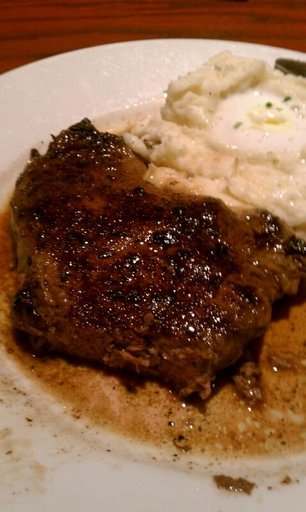

In [34]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Visualize random image
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
print(f"Image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image width x height: {img.width} x {img.height}")
img

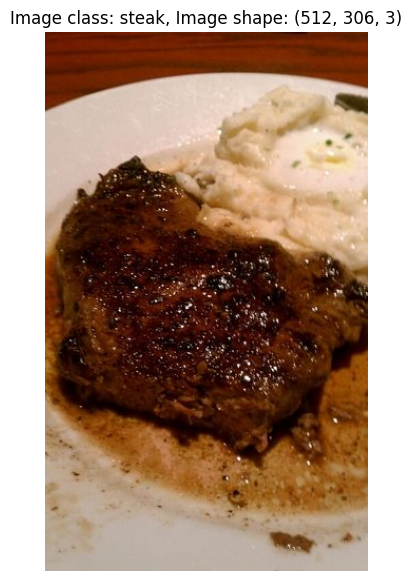

In [35]:
img = np.asarray(img)
plt.figure(figsize =(10,7))
plt.imshow(img)
plt.title(f"Image class: {image_class}, Image shape: {img.shape}")
plt.axis(False)
plt.show()

### Convert images to tensors